In [1]:
# Import

import sys
import csv
import numpy as np
import pandas as pd
import datetime
import re
import math
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, LinearRegression, RidgeCV, LassoCV
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns

maxInt = sys.maxsize

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# get column names
col_names = ['tweet_id', 'username', 'timestamp', 'num_followers', 'num_friends', 'num_retweets','num_favorites', 'entities', 'sentiment', 'mentions', 'hashtags', 'urls']

scope = 500000

In [4]:
df = pd.read_csv('/content/drive/MyDrive/TweetsCOV19.tsv', nrows=scope, header=None, sep='\t', names=col_names)
len_df = len(df)
len_df

500000

In [5]:
df

,tweet_id,username,timestamp,num_followers,num_friends,num_retweets,num_favorites,entities,sentiment,mentions,hashtags,urls
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,Mon Sep 30 22:00:37 +0000 2019,619,770,0,0,null;,2 -1,null;,null;,null;
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,null;,https://twitter.com/himalayahawk/status/117766...
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,null;,null;
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1183831524665217024,4b1f37097630a3f074ffb5afa8d885ef,Mon Oct 14 19:46:44 +0000 2019,806,382,0,0,null;,3 -1,null;,null;,https://soundcloud.com/soundslikesaka/valkyrie:-:
499996,1183831879759417344,3d3824471c702e307144c1db6df8ed78,Mon Oct 14 19:48:09 +0000 2019,111,84,16,31,zte:ZTE:-1.7326303700113288;,2 -1,null;,chinatelecom zte smartcity. intchain int eth e...,null;
499997,1183833714104643585,f5ee6a384915b3f0b69c8c9912ff34dd,Mon Oct 14 19:55:26 +0000 2019,3,39,0,0,ukraine:Ukraine:-1.6392896300533573;substance ...,1 -4,null;,null;,null;
499998,1183833751832412160,a5766a58aabca8a4e454af935d0d0ce9,Mon Oct 14 19:55:35 +0000 2019,6600,2381,0,0,null;,1 -1,carterwoodson1 Celt410,null;,null;


In [6]:
df['tweet_id'].to_csv("tweet_ids.csv", header=None, index=None) # need later

## **DATA PRE-PROCESSING & FEATURE ENGINEERING**

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%a %b %d %H:%M:%S %z %Y')

In [8]:
# Extract periodic values from timestamp
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['weekday'] = df['timestamp'].dt.dayofweek

df['hour'] = 'h_' + df['hour'].astype(str)
df['year'] = 'y_' + df['year'].astype(str)

day_of_week_dict = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df.replace({'weekday': day_of_week_dict}, inplace=True)


In [9]:
df.drop(['timestamp', 'tweet_id'], axis=1, inplace=True)

In [10]:
# Split sentiment column into positive_sentiment and negative_sentiment
df[['positive_sentiment', 'negative_sentiment']] = df.sentiment.str.split(" ",expand=True,)

In [11]:
# Features to indicate whether hashtag, mention etc. is present
df['is_hashtag'] = 0
df = df.reset_index()
df.at[df['hashtags'] == 'null;', 'is_hashtag'] = 1

df['is_mention'] = 0
df.at[df['mentions'] == 'null;', 'is_mention'] = 1

df['is_url'] = 0
df.at[df['urls'] == 'null;', 'is_url'] = 1

df['is_entity'] = 0
df.at[df['entities'] == 'null;', 'is_entity'] = 1




In [12]:
df.dtypes

index                  int64
username              object
num_followers          int64
num_friends            int64
num_retweets           int64
num_favorites          int64
entities              object
sentiment             object
mentions              object
hashtags              object
urls                  object
day                    int64
month                  int64
year                  object
hour                  object
minute                 int64
weekday               object
positive_sentiment    object
negative_sentiment    object
is_hashtag             int64
is_mention             int64
is_url                 int64
is_entity              int64
dtype: object

In [13]:
# Feature to indicate number of entities
df['num_entities'] = df.entities.str.count(':')

df['fav_per_friend'] = df['num_favorites'] / (df['num_friends']+1)
df['fav_per_follower'] = df['num_favorites'] / (df['num_followers']+1)

df['friend_per_follower'] = df['num_friends'] / (df['num_followers']+1)


## **URL Related Features**



In [14]:
urls = df[['urls', 'num_retweets']]
urls

,urls,num_retweets
0,null;,0
1,https://twitter.com/himalayahawk/status/117766...,13
2,https://goo.gl/fb/uoeiPk:-:,0
3,null;,0
4,null;,26
...,...,...
499995,https://soundcloud.com/soundslikesaka/valkyrie:-:,0
499996,null;,16
499997,null;,0
499998,null;,0


In [15]:
def get_domain(text):
    domains = re.findall('https?://([A-Za-z_0-9.-]+).*',str(text))
    if(len(domains) > 0):
        return domains[0]
    return "null"

In [16]:
urls['domain'] = urls['urls'].apply(get_domain)
df['domain'] = urls['domain']
df['domain'].fillna('null', inplace=True) 
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,username,num_followers,num_friends,num_retweets,num_favorites,entities,sentiment,mentions,hashtags,urls,day,month,year,hour,minute,weekday,positive_sentiment,negative_sentiment,is_hashtag,is_mention,is_url,is_entity,num_entities,fav_per_friend,fav_per_follower,friend_per_follower,domain
0,0,35234fe4a19cc1a3336095fb3780bcc1,619,770,0,0,null;,2 -1,null;,null;,null;,30,9,y_2019,h_22,0,Mon,2,-1,1,1,1,1,0,0.000000,0.000000,1.241935,null
1,1,ea4592f39636d87af8fb4b17b7e2e4c0,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,null;,https://twitter.com/himalayahawk/status/117766...,30,9,y_2019,h_22,1,Mon,1,-4,1,1,0,0,4,0.000879,0.000467,0.531925,twitter.com
2,2,bf05d1888dd974fa4a8679c25e2ead03,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:,30,9,y_2019,h_22,6,Mon,2,-1,1,1,0,0,6,0.000000,0.000000,0.385136,goo.gl
3,3,eb8a99bca8945eab1d006750e9b75518,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,null;,null;,30,9,y_2019,h_22,14,Mon,2,-1,1,1,1,0,4,0.000000,0.000000,0.437387,null
4,4,00695cf79d60e86a5d0f872f4358337a,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;,30,9,y_2019,h_22,26,Mon,2,-1,0,1,1,0,4,0.018002,0.009878,0.548613,null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499995,4b1f37097630a3f074ffb5afa8d885ef,806,382,0,0,null;,3 -1,null;,null;,https://soundcloud.com/soundslikesaka/valkyrie:-:,14,10,y_2019,h_19,46,Mon,3,-1,1,1,0,1,0,0.000000,0.000000,0.473358,soundcloud.com
499996,499996,3d3824471c702e307144c1db6df8ed78,111,84,16,31,zte:ZTE:-1.7326303700113288;,2 -1,null;,chinatelecom zte smartcity. intchain int eth e...,null;,14,10,y_2019,h_19,48,Mon,2,-1,0,1,1,0,2,0.364706,0.276786,0.750000,null
499997,499997,f5ee6a384915b3f0b69c8c9912ff34dd,3,39,0,0,ukraine:Ukraine:-1.6392896300533573;substance ...,1 -4,null;,null;,null;,14,10,y_2019,h_19,55,Mon,1,-4,1,1,1,0,6,0.000000,0.000000,9.750000,null
499998,499998,a5766a58aabca8a4e454af935d0d0ce9,6600,2381,0,0,null;,1 -1,carterwoodson1 Celt410,null;,null;,14,10,y_2019,h_19,55,Mon,1,-1,1,0,1,1,0,0.000000,0.000000,0.360703,null


In [17]:
groups1 = urls.groupby('domain').agg({'num_retweets': 'median'}).reset_index().rename(columns={'num_retweets': 'median_retweets'})
groups2 = urls.groupby('domain').agg({'num_retweets': 'count'}).reset_index()
groups3 = urls.groupby('domain').agg({'num_retweets': 'max'}).reset_index().rename(columns={'num_retweets': 'max_retweets'})

groups = pd.concat([groups1, groups2.drop('domain', axis=1), groups3.drop('domain', axis=1)], axis=1)

In [18]:
groups['score'] = groups['median_retweets'] * groups['num_retweets']
groups

,domain,median_retweets,num_retweets,max_retweets,score
0,042baze.com,0.0,1,0,0.0
1,0bin.net,0.0,1,0,0.0
2,0se.co,1.0,1,1,1.0
3,1.Best,0.0,1,0,0.0
4,1.It,18.0,1,18,18.0
...,...,...,...,...,...
22478,zora.medium.com,26.0,3,1904,78.0
22479,zore0114fl.com,0.0,1,0,0.0
22480,zslpublications.onlinelibrary.wiley.com,10.0,1,10,10.0
22481,zycrypto.com,5.0,1,5,5.0


In [19]:
df = pd.merge(df, groups, on='domain', how='left')
df

,index,username,num_followers,num_friends,num_retweets_x,num_favorites,entities,sentiment,mentions,hashtags,urls,day,month,year,hour,minute,weekday,positive_sentiment,negative_sentiment,is_hashtag,is_mention,is_url,is_entity,num_entities,fav_per_friend,fav_per_follower,friend_per_follower,domain,median_retweets,num_retweets_y,max_retweets,score
0,0,35234fe4a19cc1a3336095fb3780bcc1,619,770,0,0,null;,2 -1,null;,null;,null;,30,9,y_2019,h_22,0,Mon,2,-1,1,1,1,1,0,0.000000,0.000000,1.241935,null,0.0,382782,79364,0.0
1,1,ea4592f39636d87af8fb4b17b7e2e4c0,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,null;,https://twitter.com/himalayahawk/status/117766...,30,9,y_2019,h_22,1,Mon,1,-4,1,1,0,0,4,0.000879,0.000467,0.531925,twitter.com,7.0,32064,58602,224448.0
2,2,bf05d1888dd974fa4a8679c25e2ead03,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:,30,9,y_2019,h_22,6,Mon,2,-1,1,1,0,0,6,0.000000,0.000000,0.385136,goo.gl,0.0,154,8,0.0
3,3,eb8a99bca8945eab1d006750e9b75518,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,null;,null;,30,9,y_2019,h_22,14,Mon,2,-1,1,1,1,0,4,0.000000,0.000000,0.437387,null,0.0,382782,79364,0.0
4,4,00695cf79d60e86a5d0f872f4358337a,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;,30,9,y_2019,h_22,26,Mon,2,-1,0,1,1,0,4,0.018002,0.009878,0.548613,null,0.0,382782,79364,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499995,4b1f37097630a3f074ffb5afa8d885ef,806,382,0,0,null;,3 -1,null;,null;,https://soundcloud.com/soundslikesaka/valkyrie:-:,14,10,y_2019,h_19,46,Mon,3,-1,1,1,0,1,0,0.000000,0.000000,0.473358,soundcloud.com,0.0,339,1374,0.0
499996,499996,3d3824471c702e307144c1db6df8ed78,111,84,16,31,zte:ZTE:-1.7326303700113288;,2 -1,null;,chinatelecom zte smartcity. intchain int eth e...,null;,14,10,y_2019,h_19,48,Mon,2,-1,0,1,1,0,2,0.364706,0.276786,0.750000,null,0.0,382782,79364,0.0
499997,499997,f5ee6a384915b3f0b69c8c9912ff34dd,3,39,0,0,ukraine:Ukraine:-1.6392896300533573;substance ...,1 -4,null;,null;,null;,14,10,y_2019,h_19,55,Mon,1,-4,1,1,1,0,6,0.000000,0.000000,9.750000,null,0.0,382782,79364,0.0
499998,499998,a5766a58aabca8a4e454af935d0d0ce9,6600,2381,0,0,null;,1 -1,carterwoodson1 Celt410,null;,null;,14,10,y_2019,h_19,55,Mon,1,-1,1,0,1,1,0,0.000000,0.000000,0.360703,null,0.0,382782,79364,0.0


In [20]:
df.rename(columns={'num_retweets_x': 'num_retweets'}, inplace=True)

In [21]:
numeric_df = df.drop(['username', 'entities', 'urls', 'mentions', 'domain', 'hashtags', 'sentiment', 'day', 'month', 'minute', 'num_retweets_y', 'max_retweets'], axis=1)

cat_cols = ['weekday', 'hour', 'year']

In [22]:
# Perform one-hot encoding of categorical columns
for cat_col in cat_cols:
    one_hot = pd.get_dummies(numeric_df[cat_col])
    numeric_df.drop(cat_col, axis=1, inplace=True)
    numeric_df = pd.concat([numeric_df, one_hot], axis=1)

# num_df['class_retweets'] = 1
# num_df.at[num_df['num_retweets'] == 0, 'class_retweets'] = 0


numeric_df



,index,num_followers,num_friends,num_retweets,num_favorites,positive_sentiment,negative_sentiment,is_hashtag,is_mention,is_url,is_entity,num_entities,fav_per_friend,fav_per_follower,friend_per_follower,median_retweets,score,Fri,Mon,Sat,Sun,Thu,Tue,Wed,h_0,h_1,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_2,h_20,h_21,h_22,h_23,h_3,h_4,h_5,h_6,h_7,h_8,h_9,y_2019
0,0,619,770,0,0,2,-1,1,1,1,1,0,0.000000,0.000000,1.241935,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1,36365,19344,13,17,1,-4,1,1,0,0,4,0.000879,0.000467,0.531925,7.0,224448.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,2,5018,1933,0,0,2,-1,1,1,0,0,6,0.000000,0.000000,0.385136,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,3,2219,971,0,0,2,-1,1,1,1,0,4,0.000000,0.000000,0.437387,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,4,9009,4943,26,89,2,-1,0,1,1,0,4,0.018002,0.009878,0.548613,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499995,806,382,0,0,3,-1,1,1,0,1,0,0.000000,0.000000,0.473358,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
499996,499996,111,84,16,31,2,-1,0,1,1,0,2,0.364706,0.276786,0.750000,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
499997,499997,3,39,0,0,1,-4,1,1,1,0,6,0.000000,0.000000,9.750000,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
499998,499998,6600,2381,0,0,1,-1,1,0,1,1,0,0.000000,0.000000,0.360703,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


# **REGRESSION**



## **Base Line Models**

In [23]:
sorted_numeric_df = numeric_df.sort_values(by=['median_retweets'], ascending=False)

min_cutoff_groups =(sorted_numeric_df[sorted_numeric_df['num_retweets'] >= 10])
cutoff_groups =(min_cutoff_groups[sorted_numeric_df['num_retweets'] <= 100])

print(len(cutoff_groups))
cutoff_groups

81949


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,index,num_followers,num_friends,num_retweets,num_favorites,positive_sentiment,negative_sentiment,is_hashtag,is_mention,is_url,is_entity,num_entities,fav_per_friend,fav_per_follower,friend_per_follower,median_retweets,score,Fri,Mon,Sat,Sun,Thu,Tue,Wed,h_0,h_1,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_2,h_20,h_21,h_22,h_23,h_3,h_4,h_5,h_6,h_7,h_8,h_9,y_2019
313478,313478,50765,4609,20,47,1,-1,1,0,0,0,2,0.010195,0.000926,0.090789,1550.0,3100.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
60226,60226,12125,75,60,62,1,-1,1,1,0,1,0,0.815789,0.005113,0.006185,1392.5,2785.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
55586,55586,14776,1025,46,35,2,-1,1,0,0,1,0,0.034113,0.002369,0.069365,895.0,1790.0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
182153,182153,12049,43,13,20,3,-1,0,0,0,0,10,0.454545,0.001660,0.003568,865.5,1731.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
211292,211292,7915,7694,13,19,2,-1,1,0,0,0,4,0.002469,0.002400,0.971956,542.0,1084.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181969,181969,12075,12184,29,27,1,-1,0,0,1,0,4,0.002216,0.002236,1.008943,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
182005,182005,44376,593,43,182,1,-1,1,0,1,0,4,0.306397,0.004101,0.013363,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
182002,182002,159,317,18,65,2,-1,0,1,1,0,10,0.204403,0.406250,1.981250,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
181996,181996,91986,7913,91,188,1,-1,1,1,1,1,0,0.023755,0.002044,0.086023,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [24]:
cutoff_groups['num_retweets'].describe() # Final cutoff groups for number of retweets between 10-100

count    81949.000000
mean        35.628281
std         23.774175
min         10.000000
25%         16.000000
50%         28.000000
75%         50.000000
max        100.000000
Name: num_retweets, dtype: float64

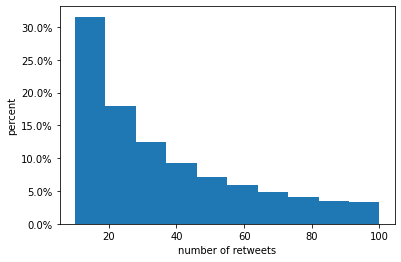

In [25]:
from matplotlib.ticker import PercentFormatter

data = cutoff_groups['num_retweets']
plt.hist(data, weights=np.ones(len(data)) / len(data))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('number of retweets')
plt.ylabel('percent')
plt.show()

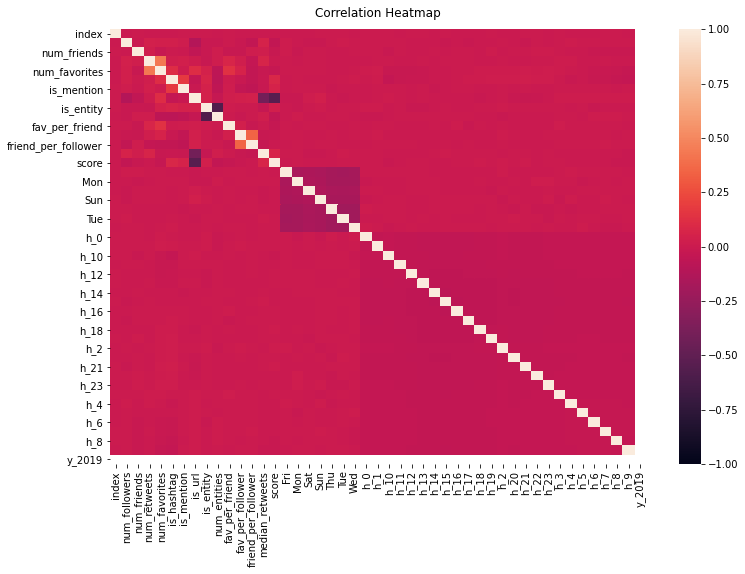

In [26]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(cutoff_groups.corr(), vmin=-1, vmax=1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## 1. Linear Regression

In [27]:
X = cutoff_groups.loc[:, cutoff_groups.columns != 'num_retweets']
X = X.loc[:, X.columns != 'y_2019']

y = cutoff_groups['num_retweets']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state=0)

X_test = X_test.fillna(0.0)
len(X_test), len(X_train), len(y_train)
X_test.columns

Index(['index', 'num_followers', 'num_friends', 'num_favorites',
       'positive_sentiment', 'negative_sentiment', 'is_hashtag', 'is_mention',
       'is_url', 'is_entity', 'num_entities', 'fav_per_friend',
       'fav_per_follower', 'friend_per_follower', 'median_retweets', 'score',
       'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'h_0', 'h_1', 'h_10',
       'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19',
       'h_2', 'h_20', 'h_21', 'h_22', 'h_23', 'h_3', 'h_4', 'h_5', 'h_6',
       'h_7', 'h_8', 'h_9'],
      dtype='object')

In [28]:
lr = LinearRegression(normalize= True)
lr.fit(X_train, y_train) #training the algorithm 
y_pred_lr = lr.predict(X_test)
y_pred_lr

array([29.375 , 46.875 , 30.5625, ..., 33.4375, 30.75  , 29.375 ])

In [29]:
print("MSLE for Linear Regression = ",mean_squared_log_error(y_test,y_pred_lr))
print("RMSE for Linear Regression = ", mean_squared_error(y_test,y_pred_lr, squared=False))
print("MAE for Linear Regression = ", mean_absolute_error(y_test,y_pred_lr))

MSLE for Linear Regression =  0.3432264378728536
RMSE for Linear Regression =  21.02203050310458
MAE for Linear Regression =  16.615909090909092


## 2. Ridge Regression

In [30]:
X = cutoff_groups.loc[:, cutoff_groups.columns != 'num_retweets']
y = cutoff_groups['num_retweets']
X = X.loc[:, X.columns != 'y_2019']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state=0)

X_test = X_test.fillna(0.0)
len(X_test), len(X_train), len(y_train)

(16390, 65559, 65559)

In [31]:
ridge_reg = RidgeCV(normalize=True, alphas=[1e-3, 1e-2, 1e-1, 1], cv=10)
ridge_reg.fit(X_train, y_train) #training the algorithm 
y_pred_ridge_reg = ridge_reg.predict(X_test)
y_pred_ridge_reg

array([29.8119358 , 46.94529298, 30.84949677, ..., 33.84949182,
       31.02942682, 29.22802264])

In [32]:
print("MSLE for Ridge Regression = ",mean_squared_log_error(y_test,y_pred_ridge_reg))
print("RMSE for Ridge Regression = ", mean_squared_error(y_test,y_pred_ridge_reg, squared=False))
print("MAE for Ridge Regression = ", mean_absolute_error(y_test,y_pred_ridge_reg))

MSLE for Ridge Regression =  0.344788260898866
RMSE for Ridge Regression =  21.02186624854039
MAE for Ridge Regression =  16.648558918143085


## 3. LASSO Regression

In [33]:
X = cutoff_groups.loc[:, cutoff_groups.columns != 'num_retweets']
y = cutoff_groups['num_retweets']
X = X.loc[:, X.columns != 'y_2019']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state=0)

X_test = X_test.fillna(0.0)
len(X_test), len(X_train), len(y_train)

(16390, 65559, 65559)

In [34]:
lasso = LassoCV(normalize=True, cv=10, alphas=[1e-3, 1e-2, 1e-1, 1], random_state=0)
lasso.fit(X_train, y_train) #training the algorithm 
y_pred_lasso = lasso.predict(X_test)
y_pred_lasso

array([29.21959175, 48.97491187, 30.77857176, ..., 32.66180502,
       30.39768204, 30.29566359])

In [35]:
print("MSLE for LASSO Regression = ",mean_squared_log_error(y_test,y_pred_lasso))
print("RMSE for LASSO Regression = ", mean_squared_error(y_test,y_pred_lasso, squared=False))
print("MAE for LASSO Regression = ", mean_absolute_error(y_test,y_pred_lasso))

MSLE for LASSO Regression =  0.34720963436490876
RMSE for LASSO Regression =  21.042137212899657
MAE for LASSO Regression =  16.71496600239368


## 4. Decision Tree Regressor

In [44]:
X = cutoff_groups.loc[:, cutoff_groups.columns != 'num_retweets']
X = X.loc[:, X.columns != 'y_2019']
y = cutoff_groups['num_retweets']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state=0)

X_test = X_test.fillna(0.0)
len(X_test), len(X_train), len(y_train)

(16390, 65559, 65559)

In [46]:
 from sklearn.tree import DecisionTreeRegressor

 dt_reg = DecisionTreeRegressor(random_state=0, criterion='friedman_mse', ccp_alpha=0.1)
 dt_reg.fit(X_train, y_train)
 y_pred_dt = dt_reg.predict(X_test)
 y_pred_dt

array([17.55834018, 57.06896552, 23.71551402, ..., 39.25128205,
       16.80290842, 23.20234785])

50274


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

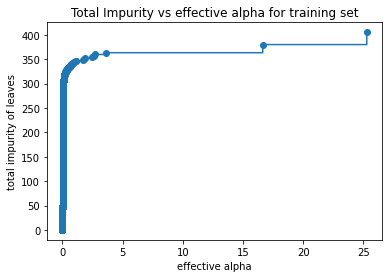

In [47]:
path = dt_reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(len(ccp_alphas))
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
#https://medium.com/swlh/post-pruning-decision-trees-using-python-b5d4bcda8e23

In [48]:
print("MSLE for Decision Tree Regressor = ", mean_squared_log_error(y_test, y_pred_dt))
print("RMSE for Decision Tree Regressor = ", mean_squared_error(y_test, y_pred_dt, squared=False))
print("MAE for Decision Tree Regressor = ", mean_absolute_error(y_test, y_pred_dt))

MSLE for Decision Tree Regressor =  0.2348261806707733
RMSE for Decision Tree Regressor =  17.81443092387831
MAE for Decision Tree Regressor =  13.400869103774772


## 5. Random Forest Regressor

In [36]:
X = cutoff_groups.loc[:, cutoff_groups.columns != 'num_retweets']
y = cutoff_groups['num_retweets']
X = X.loc[:, X.columns != 'y_2019']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state=0)

X_test = X_test.fillna(0.0)
len(X_test), len(X_train), len(y_train)

(16390, 65559, 65559)

In [37]:
regressor = RandomForestRegressor(random_state=100, n_estimators=800, warm_start=True)
regressor.fit(X_train, y_train) #training the algorithm 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=True)

In [38]:
y_pred = regressor.predict(X_test)

In [39]:
# Post-processing

X_test['num_predicted'] = y_pred.flatten()

X_test = X_test.reset_index(level=0, drop=True)
X_test.at[X_test['num_favorites'] == 0, 'num_predicted'] = 0

In [40]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
result_df['num_predicted'] = X_test['num_predicted'].astype(int)

In [41]:
print("MSLE for Random Forest Regressor = ", mean_squared_log_error(result_df['Actual'], result_df['Predicted']))
print("RMSE for Random Forest Regressor = ", mean_squared_error(result_df['Actual'], result_df['Predicted'], squared=False))
print("MAE for Random Forest Regressor = ", mean_absolute_error(result_df['Actual'], result_df['Predicted']))

MSLE for Random Forest Regressor =  0.2274860401047373
RMSE for Random Forest Regressor =  17.43640322730704
MAE for Random Forest Regressor =  13.060426403294692


In [42]:
result_df['final_num_predicted'] = result_df['num_predicted']

In [43]:
result_df.describe()

,Actual,Predicted,num_predicted,final_num_predicted
count,16390.000000,16390.000000,504.000000,504.000000
mean,35.336669,35.910570,37.273810,37.273810
std,23.573783,16.210524,15.872893,15.872893
min,10.000000,10.463750,0.000000,0.000000
25%,16.000000,21.703750,23.000000,23.000000
50%,28.000000,32.483125,36.500000,36.500000
75%,49.000000,48.525000,51.000000,51.000000
max,100.000000,90.637500,80.000000,80.000000


## 6. Gradient Boosted Regressor

In [49]:
X = cutoff_groups.loc[:, cutoff_groups.columns != 'num_retweets']
X = X.loc[:, X.columns != 'y_2019']
y = cutoff_groups['num_retweets']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state=0)

X_test = X_test.fillna(0.0)
len(X_test), len(X_train), len(y_train)

(16390, 65559, 65559)

In [50]:
 reg = GradientBoostingRegressor(random_state=0, n_estimators=1000, loss='huber', warm_start=True)
 reg.fit(X_train, y_train)
 y_pred_gb = reg.predict(X_test)
 y_pred_gb

array([19.8946955 , 47.40891702, 22.89868972, ..., 44.85470731,
       21.04314893, 20.79780626])

In [51]:
reg.score(X_test, y_test)

0.46289625926963823

In [52]:
print("MSLE for Gradient Boosted Regressor = ", mean_squared_log_error(y_test, y_pred_gb))
print("RMSE for Gradient Boosted Regressor = ", mean_squared_error(y_test, y_pred_gb, squared=False))
print("MAE for Gradient Boosted Regressor = ", mean_absolute_error(y_test, y_pred_gb))

MSLE for Gradient Boosted Regressor =  0.21672785210114934
RMSE for Gradient Boosted Regressor =  17.2760765952967
MAE for Gradient Boosted Regressor =  12.781400254537326


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if sys.path[0] == '':


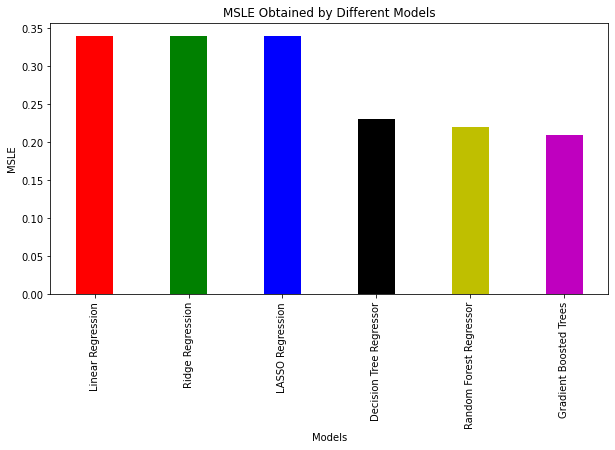

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/RT_Prediction_output.csv')

fig = plt.figure(figsize=(10, 5))

my_colors = 'rgbkymc'

# creating the bar plot
plt.bar(df['Models'], df['MSLE'], color=my_colors,
        width=0.4)
plt.xticks(rotation=90)

plt.xlabel("Models")
plt.ylabel("MSLE")
plt.title("MSLE Obtained by Different Models")
plt.show()